In [112]:
import numpy as np
from partition_decode.dataset import generate_gaussian_parity, recursive_gaussian_parity, generate_spirals, load_mnist
from partition_decode.df_utils import get_tree_evals, get_forest_evals, get_forest_irm, get_tree_irm
from partition_decode.models import ReluNetClassifier, ReluNetRegressor
from partition_decode.metrics import irm2activations, score_matrix_representation, fast_evals
import torch
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import zero_one_loss, log_loss, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [175]:
def hidden_to_params(h, k=2, d=2):
    return (d+1) * h + (h+1) * k

def get_units_at_interp(n, k=2, d=2):
    # n k = (d+1) H + (H+1) k
    # n k = (d+1) H + k H + k
    return np.ceil((n * k - k) / (d + 1 + k)).astype(int)

In [176]:
def get_eigenval_metrics(irm):
    metric_params = [
        {'metric': 'norm', 'p': 1},
        {'metric': 'norm', 'p': 2},
        {'metric': 'n_regions'},
        {'metric': 'norm', 'p': 2, 'regions': True},
        {'metric': 'h*'},
        {'metric': 'h*', 'regions': True},
        {'metric': 'entropy'},
        {'metric': 'row_means', 'p': 2},
        {'metric': 'col_means', 'p': 1},
        {'metric': 'col_means', 'p': 2},
    ]

    # Prune columns that are the same
    irm = irm[:, ~np.all(irm[1:] == irm[:-1], axis=0)]

    metrics = []
    evals = fast_evals(irm)
    for params in metric_params:
        if params['metric'] in ['norm', 'h*', 'entropy'] and (
            'regions' not in list(params.keys())
        ):
            metrics.append(
                score_matrix_representation(evals, is_evals=True, **params)
            )
        else:
            metrics.append(
                score_matrix_representation(irm, **params)
            )
    return metrics

def run_network(X_train, y_train, X_test, model_params, model):
    model = ReluNetRegressor(**model_params)

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    irm = model.get_internal_representation(X_train, penultimate=False)

    model_metrics = get_eigenval_metrics(irm)
    model_metrics += [
        model.n_parameters_, len(model.hidden_layer_dims),
        model.hidden_layer_dims[0]
        ]

    return model, y_train_pred, y_test_pred, model_metrics


def get_y_metrics(y_true, y_pred):
    errors = [
        mean_squared_error(y_true, y_pred),
    ]
    return errors

## Load MNIST

In [183]:
from torchvision import datasets, transforms
from torch import nn

n_train = 4000

train_set = datasets.MNIST('/mnt/ssd3/ronan/pytorch', train=True, download=True)
X_train = train_set.data.numpy()[:n_train]
X_train = X_train.reshape((n_train, -1))
y_train = nn.functional.one_hot(train_set.targets).numpy()[:n_train]
del train_set

min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)

test_set = datasets.MNIST('/mnt/ssd3/ronan/pytorch', train=False, download=True)
X_test = test_set.data.numpy()
X_test = X_test.reshape((X_test.shape[0], -1))
X_test = min_max_scaler.transform(X_test)
y_test = nn.functional.one_hot(test_set.targets).numpy()
del test_set

print(X_train.shape, y_train.shape)

(4000, 784) (4000, 10)


In [184]:
idx = np.where(((y_train[:, 0] == 1) | (y_train[:, 1] == 1)))

In [185]:
n_hidden = get_units_at_interp(n_train, k=y_train.shape[1], d=X_train.shape[1])
print(f'{n_hidden} hidden units')

51 hidden units


In [194]:
model = ReluNetRegressor(hidden_layer_dims=[100], n_epochs=6000, learning_rate=1e-2, batch_size=32, verbose=1)
model.fit(X_train, y_train)

Results for epoch 1, MSELoss=0.05, mse=0.05
Results for epoch 6, MSELoss=0.03, mse=0.03
Results for epoch 11, MSELoss=0.02, mse=0.02
Results for epoch 16, MSELoss=0.02, mse=0.02
Results for epoch 21, MSELoss=0.01, mse=0.01
Results for epoch 26, MSELoss=0.01, mse=0.01
Results for epoch 31, MSELoss=0.01, mse=0.01
Results for epoch 36, MSELoss=0.01, mse=0.01
Results for epoch 41, MSELoss=0.01, mse=0.01
Results for epoch 46, MSELoss=0.01, mse=0.01
Results for epoch 51, MSELoss=0.01, mse=0.01
Results for epoch 56, MSELoss=0.01, mse=0.01
Results for epoch 61, MSELoss=0.01, mse=0.01
Results for epoch 66, MSELoss=0.01, mse=0.01
Results for epoch 71, MSELoss=0.01, mse=0.01
Results for epoch 76, MSELoss=0.01, mse=0.01
Results for epoch 81, MSELoss=0.00, mse=0.00
Results for epoch 86, MSELoss=0.01, mse=0.01
Results for epoch 91, MSELoss=0.01, mse=0.01
Results for epoch 96, MSELoss=0.01, mse=0.01
Results for epoch 101, MSELoss=0.01, mse=0.01
Results for epoch 106, MSELoss=0.00, mse=0.00
Results fo

Results for epoch 896, MSELoss=0.00, mse=0.00
Results for epoch 901, MSELoss=0.00, mse=0.00
Results for epoch 906, MSELoss=0.00, mse=0.00
Results for epoch 911, MSELoss=0.00, mse=0.00
Results for epoch 916, MSELoss=0.00, mse=0.00
Results for epoch 921, MSELoss=0.00, mse=0.00
Results for epoch 926, MSELoss=0.00, mse=0.00
Results for epoch 931, MSELoss=0.00, mse=0.00
Results for epoch 936, MSELoss=0.00, mse=0.00
Results for epoch 941, MSELoss=0.00, mse=0.00
Results for epoch 946, MSELoss=0.00, mse=0.00
Results for epoch 951, MSELoss=0.00, mse=0.00
Results for epoch 956, MSELoss=0.00, mse=0.00
Results for epoch 961, MSELoss=0.00, mse=0.00
Results for epoch 966, MSELoss=0.00, mse=0.00
Results for epoch 971, MSELoss=0.00, mse=0.00
Results for epoch 976, MSELoss=0.00, mse=0.00
Results for epoch 981, MSELoss=0.00, mse=0.00
Results for epoch 986, MSELoss=0.00, mse=0.00
Results for epoch 991, MSELoss=0.00, mse=0.00
Results for epoch 996, MSELoss=0.00, mse=0.00
Results for epoch 1001, MSELoss=0.

Results for epoch 1771, MSELoss=0.00, mse=0.00
Results for epoch 1776, MSELoss=0.00, mse=0.00
Results for epoch 1781, MSELoss=0.00, mse=0.00
Results for epoch 1786, MSELoss=0.00, mse=0.00
Results for epoch 1791, MSELoss=0.00, mse=0.00
Results for epoch 1796, MSELoss=0.00, mse=0.00
Results for epoch 1801, MSELoss=0.00, mse=0.00
Results for epoch 1806, MSELoss=0.00, mse=0.00
Results for epoch 1811, MSELoss=0.00, mse=0.00
Results for epoch 1816, MSELoss=0.00, mse=0.00
Results for epoch 1821, MSELoss=0.00, mse=0.00
Results for epoch 1826, MSELoss=0.00, mse=0.00
Results for epoch 1831, MSELoss=0.00, mse=0.00
Results for epoch 1836, MSELoss=0.00, mse=0.00
Results for epoch 1841, MSELoss=0.00, mse=0.00
Results for epoch 1846, MSELoss=0.00, mse=0.00
Results for epoch 1851, MSELoss=0.00, mse=0.00
Results for epoch 1856, MSELoss=0.00, mse=0.00
Results for epoch 1861, MSELoss=0.00, mse=0.00
Results for epoch 1866, MSELoss=0.00, mse=0.00
Results for epoch 1871, MSELoss=0.00, mse=0.00
Results for e

Results for epoch 2646, MSELoss=0.00, mse=0.00
Results for epoch 2651, MSELoss=0.00, mse=0.00
Results for epoch 2656, MSELoss=0.00, mse=0.00
Results for epoch 2661, MSELoss=0.00, mse=0.00
Results for epoch 2666, MSELoss=0.00, mse=0.00
Results for epoch 2671, MSELoss=0.00, mse=0.00
Results for epoch 2676, MSELoss=0.00, mse=0.00
Results for epoch 2681, MSELoss=0.00, mse=0.00
Results for epoch 2686, MSELoss=0.00, mse=0.00
Results for epoch 2691, MSELoss=0.00, mse=0.00
Results for epoch 2696, MSELoss=0.00, mse=0.00
Results for epoch 2701, MSELoss=0.00, mse=0.00
Results for epoch 2706, MSELoss=0.00, mse=0.00
Results for epoch 2711, MSELoss=0.00, mse=0.00
Results for epoch 2716, MSELoss=0.00, mse=0.00
Results for epoch 2721, MSELoss=0.00, mse=0.00
Results for epoch 2726, MSELoss=0.00, mse=0.00
Results for epoch 2731, MSELoss=0.00, mse=0.00
Results for epoch 2736, MSELoss=0.00, mse=0.00
Results for epoch 2741, MSELoss=0.00, mse=0.00
Results for epoch 2746, MSELoss=0.00, mse=0.00
Results for e

Results for epoch 3521, MSELoss=0.00, mse=0.00
Results for epoch 3526, MSELoss=0.00, mse=0.00
Results for epoch 3531, MSELoss=0.00, mse=0.00
Results for epoch 3536, MSELoss=0.00, mse=0.00
Results for epoch 3541, MSELoss=0.00, mse=0.00
Results for epoch 3546, MSELoss=0.00, mse=0.00
Results for epoch 3551, MSELoss=0.00, mse=0.00
Results for epoch 3556, MSELoss=0.00, mse=0.00
Results for epoch 3561, MSELoss=0.00, mse=0.00
Results for epoch 3566, MSELoss=0.00, mse=0.00
Results for epoch 3571, MSELoss=0.00, mse=0.00
Results for epoch 3576, MSELoss=0.00, mse=0.00
Results for epoch 3581, MSELoss=0.00, mse=0.00
Results for epoch 3586, MSELoss=0.00, mse=0.00
Results for epoch 3591, MSELoss=0.00, mse=0.00
Results for epoch 3596, MSELoss=0.00, mse=0.00
Results for epoch 3601, MSELoss=0.00, mse=0.00
Results for epoch 3606, MSELoss=0.00, mse=0.00
Results for epoch 3611, MSELoss=0.00, mse=0.00
Results for epoch 3616, MSELoss=0.00, mse=0.00
Results for epoch 3621, MSELoss=0.00, mse=0.00
Results for e

Results for epoch 4396, MSELoss=0.00, mse=0.00
Results for epoch 4401, MSELoss=0.00, mse=0.00
Results for epoch 4406, MSELoss=0.00, mse=0.00
Results for epoch 4411, MSELoss=0.00, mse=0.00
Results for epoch 4416, MSELoss=0.00, mse=0.00
Results for epoch 4421, MSELoss=0.00, mse=0.00
Results for epoch 4426, MSELoss=0.00, mse=0.00
Results for epoch 4431, MSELoss=0.00, mse=0.00
Results for epoch 4436, MSELoss=0.00, mse=0.00
Results for epoch 4441, MSELoss=0.00, mse=0.00
Results for epoch 4446, MSELoss=0.00, mse=0.00
Results for epoch 4451, MSELoss=0.00, mse=0.00
Results for epoch 4456, MSELoss=0.00, mse=0.00
Results for epoch 4461, MSELoss=0.00, mse=0.00
Results for epoch 4466, MSELoss=0.00, mse=0.00
Results for epoch 4471, MSELoss=0.00, mse=0.00
Results for epoch 4476, MSELoss=0.00, mse=0.00
Results for epoch 4481, MSELoss=0.00, mse=0.00
Results for epoch 4486, MSELoss=0.00, mse=0.00
Results for epoch 4491, MSELoss=0.00, mse=0.00
Results for epoch 4496, MSELoss=0.00, mse=0.00
Results for e

Results for epoch 5271, MSELoss=0.00, mse=0.00
Results for epoch 5276, MSELoss=0.00, mse=0.00
Results for epoch 5281, MSELoss=0.00, mse=0.00
Results for epoch 5286, MSELoss=0.00, mse=0.00
Results for epoch 5291, MSELoss=0.00, mse=0.00
Results for epoch 5296, MSELoss=0.00, mse=0.00
Results for epoch 5301, MSELoss=0.00, mse=0.00
Results for epoch 5306, MSELoss=0.00, mse=0.00
Results for epoch 5311, MSELoss=0.00, mse=0.00
Results for epoch 5316, MSELoss=0.00, mse=0.00
Results for epoch 5321, MSELoss=0.00, mse=0.00
Results for epoch 5326, MSELoss=0.00, mse=0.00
Results for epoch 5331, MSELoss=0.00, mse=0.00
Results for epoch 5336, MSELoss=0.00, mse=0.00
Results for epoch 5341, MSELoss=0.00, mse=0.00
Results for epoch 5346, MSELoss=0.00, mse=0.00
Results for epoch 5351, MSELoss=0.00, mse=0.00
Results for epoch 5356, MSELoss=0.00, mse=0.00
Results for epoch 5361, MSELoss=0.00, mse=0.00
Results for epoch 5366, MSELoss=0.00, mse=0.00
Results for epoch 5371, MSELoss=0.00, mse=0.00
Results for e

ReluNetRegressor(hidden_layer_dims=[100], n_epochs=6000, verbose=1)

In [158]:
model.predict(X_train)[4]

array([ 0.12269337,  0.19014081, -0.05143097, -0.16025934,  0.37524787,
        0.04100078, -0.04888862,  0.14109677,  0.14058265,  0.69652975],
      dtype=float32)

In [159]:
y_train[:5].argmax(1)

array([5, 0, 4, 1, 9])

In [196]:
np.mean(y_test.argmax(1) == model.predict(X_test).argmax(1))

0.9198

In [68]:
results = [[
    'hidden_layer_dims',
    'train_mse',
    'test_mse',   
] + [
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2', 'IRM_h*', 'ACTS_h*', 'entropy',
    'rows_mean_L2', 'cols_mean_L1', 'cols_mean_L2'
] + [
    'n_parameters', 'depth', 'width'
]]

NETWORK_PARAMS = {
    'hidden_layer_dims': [
        [4],
        [8],
        [16],
        [32],
        [40],
        [45],
        [47],
        [51],
        [55],
        [60],
        [100]
    ],
    'n_epochs': [6000],# [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],# 2048],
    'learning_rate': [1e-5],
    'batch_size': [128],
    'verbose': [0],
    'early_stop_thresh': [0],
    "bias": [True],
}

In [46]:
keys, values = zip(*NETWORK_PARAMS.items())
model_params_grid = [dict(zip(keys, v)) for v in itertools.product(*values)]

model = None
for model_params in tqdm(model_params_grid):
    # Train and test model
    model, y_train_pred, y_test_pred, model_metrics = run_network(
        X_train, y_train, X_test, model_params, model
    )

    # Compute metrics
    results += [
        [model_params['hidden_layer_dims'][0]]
        + get_y_metrics(y_train, y_train_pred)  # Train
        + get_y_metrics(y_test, y_test_pred)  # Test
        + model_metrics
    ]

  0%|          | 0/11 [00:00<?, ?it/s]/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
  9%|▉         | 1/11 [00:24<04:06, 24.63s/it]/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
 18%|█▊        | 2/11 [00:48<03:37, 24.17s/it]/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty 

In [52]:
df = pd.DataFrame(results[1:], columns=results[0])

In [53]:
df

,hidden_layer_dims,train_mse,test_mse,IRM_L1,IRM_L2,n_regions,ACTS_L2,IRM_h*,ACTS_h*,entropy,rows_mean_L2,cols_mean_L1,cols_mean_L2,n_parameters,depth,width
0,4,0.106076,0.105824,0.0,0.000000,1,4000.000000,0,1,0.000000,0.000000,NaN,NaN,3190,1,4
1,8,0.095577,0.095876,0.0,0.000000,1,4000.000000,0,1,0.000000,0.000000,NaN,NaN,6370,1,8
2,16,0.099826,0.099614,0.0,0.000000,1,4000.000000,0,1,0.000000,0.000000,NaN,NaN,12730,1,16
3,32,0.096874,0.097081,0.0,0.000000,1,4000.000000,0,1,0.000000,0.000000,NaN,NaN,25450,1,32
4,40,0.094460,0.094446,0.0,0.000000,1,4000.000000,0,1,0.000000,0.000000,NaN,NaN,31810,1,40
5,45,0.095907,0.095761,0.0,0.000000,1,4000.000000,0,1,0.000000,0.000000,NaN,NaN,35785,1,45
6,47,0.094762,0.095428,0.0,0.000000,1,4000.000000,0,1,0.000000,0.000000,NaN,NaN,37375,1,47
7,51,0.096960,0.105569,2.0,2.000000,2,3998.000500,1,2,1.386294,0.000500,2.0,1.414214,40555,1,51
8,55,0.095232,0.101232,0.0,0.000000,1,4000.000000,0,1,0.000000,0.000000,NaN,NaN,43735,1,55
9,60,0.093815,0.093831,0.0,0.000000,1,4000.000000,0,1,0.000000,0.000000,NaN,NaN,47710,1,60


In [54]:
train_error = 'train_mse'
test_error = 'test_mse'

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]

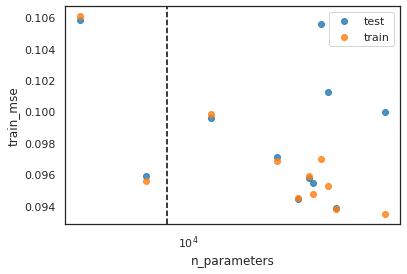

In [55]:
sns.set_style('white')
sns.set_context('notebook')

fig, ax = plt.subplots(1, 1, sharex=True)

sns.regplot(data=df, x='n_parameters', y=test_error, lowess=False, ax=ax, label='test', fit_reg=False)
sns.regplot(data=df, x='n_parameters', y=train_error, lowess=False, ax=ax, label='train', fit_reg=False)
# sns.regplot(data=df, x='n_parameters', y='generalization_gap', lowess=False, ax=ax, label='gen_gap')

ax.axvline(len(np.unique(y_train))*n_train, ls='--', c='black')
plt.xscale('log')
# plt.yscale('symlog')
plt.legend()
plt.show()

In [51]:
corr_vars = [
    'generalization_gap',
    'n_parameters', 'depth', 'width', # 'n_epochs',
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', 'entropy',
    'rows_mean_L2',
    'cols_mean_L1', 'cols_mean_L2',
]

corr_df = df[corr_vars].corr('kendall')
display(corr_df)

,generalization_gap,n_parameters,depth,width,IRM_L1,IRM_L2,n_regions,ACTS_L2,IRM_h*,ACTS_h*,entropy,rows_mean_L2,cols_mean_L1,cols_mean_L2
generalization_gap,1.000000,0.490909,NaN,0.490909,0.525885,0.587754,0.525885,-0.525885,0.525885,0.525885,0.426401,0.587754,1.0,1.0
n_parameters,0.490909,1.000000,NaN,1.000000,0.464016,0.402147,0.464016,-0.464016,0.464016,0.464016,0.170561,0.402147,-1.0,-1.0
depth,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
width,0.490909,1.000000,NaN,1.000000,0.464016,0.402147,0.464016,-0.464016,0.464016,0.464016,0.170561,0.402147,-1.0,-1.0
IRM_L1,0.525885,0.464016,NaN,0.464016,1.000000,0.894737,1.000000,-1.000000,1.000000,1.000000,0.580381,0.894737,-1.0,-1.0
IRM_L2,0.587754,0.402147,NaN,0.402147,0.894737,1.000000,0.894737,-0.894737,0.894737,0.894737,0.725476,1.000000,1.0,1.0
n_regions,0.525885,0.464016,NaN,0.464016,1.000000,0.894737,1.000000,-1.000000,1.000000,1.000000,0.580381,0.894737,-1.0,-1.0
ACTS_L2,-0.525885,-0.464016,NaN,-0.464016,-1.000000,-0.894737,-1.000000,1.000000,-1.000000,-1.000000,-0.580381,-0.894737,1.0,1.0
IRM_h*,0.525885,0.464016,NaN,0.464016,1.000000,0.894737,1.000000,-1.000000,1.000000,1.000000,0.580381,0.894737,-1.0,-1.0
ACTS_h*,0.525885,0.464016,NaN,0.464016,1.000000,0.894737,1.000000,-1.000000,1.000000,1.000000,0.580381,0.894737,-1.0,-1.0


## XOR

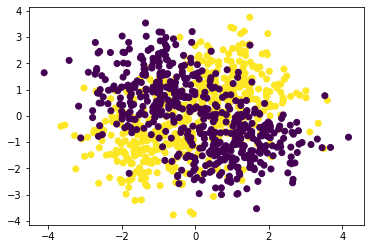

In [12]:
n_train = 1024

X_train, y_train = generate_gaussian_parity(
    n_samples=n_train, angle_params=0, random_state=0, cov_scale=1
)

X_test, y_test = generate_gaussian_parity(
    n_samples=10000, angle_params=0, random_state=1234, cov_scale=1
)

import matplotlib.pyplot as plt
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.show()

In [13]:
n_hidden = get_units_at_interp(n_train, k=len(np.unique(y_train)), d=X_train.shape[-1])
print(f'{n_hidden} hidden units')

512 hidden units


In [14]:
results = [[
    'hidden_layer_dims',
    'train_01_error',
    'train_mse',
    'test_01_error',
    'test_mse',   
] + [
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2', 'IRM_h*', 'ACTS_h*', 'entropy',
    'rows_mean_L2', 'cols_mean_L1', 'cols_mean_L2'
] + [
    'n_parameters', 'depth', 'width'
]]

NETWORK_PARAMS = {
    'hidden_layer_dims': [
        [100],
        [300],
        [450],
        [500],
        [512],
        [550],
        [600],
        [1000]
    ],
    'n_epochs': [1000],# [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],# 2048],
    'learning_rate': [1e-5],
    'batch_size': [128],
    'verbose': [0],
    'early_stop_thresh': [0],
    "bias": [True],
    # "loss": [torch.nn.MSELoss],
}

In [15]:
keys, values = zip(*NETWORK_PARAMS.items())
model_params_grid = [dict(zip(keys, v)) for v in itertools.product(*values)]

model = None
for model_params in tqdm(model_params_grid):
    # Train and test model
    model, y_train_pred, y_test_pred, model_metrics = run_network(
        X_train, y_train, X_test, model_params, model
    )

    # Compute metrics
    results += [
        [model_params['hidden_layer_dims'][0]]
        + get_y_metrics(y_train, y_train_pred)  # Train
        + get_y_metrics(y_test, y_test_pred)  # Test
        + model_metrics
    ]

100%|██████████| 8/8 [02:09<00:00, 16.16s/it]


In [16]:
df = pd.DataFrame(results[1:], columns=results[0])

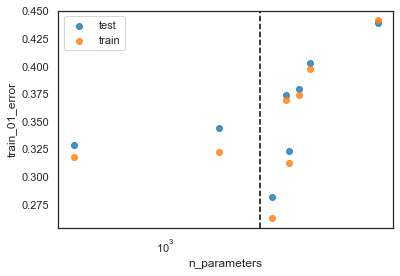

In [17]:
train_error = 'train_01_error'
test_error = 'test_01_error'

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]

sns.set_style('white')
sns.set_context('notebook')

fig, ax = plt.subplots(1, 1, sharex=True)

sns.regplot(data=df, x='n_parameters', y=test_error, lowess=False, ax=ax, label='test', fit_reg=False)
sns.regplot(data=df, x='n_parameters', y=train_error, lowess=False, ax=ax, label='train', fit_reg=False)
# sns.regplot(data=df, x='n_parameters', y='generalization_gap', lowess=False, ax=ax, label='gen_gap')

ax.axvline(len(np.unique(y_train))*n_train, ls='--', c='black')
plt.xscale('log')
# plt.yscale('symlog')
plt.legend()
plt.show()